In [4]:
from datasets import load_from_disk
from cnn_dataset import CNNDMDistillationDataset

In [5]:
# load local saved CNN/DailyMail dataset
dataset_path = "/home/zyq/experiment_Wasserstein_Distillation/experiment_DistillBERT/cnn_data/CNN"
dataset = load_from_disk(dataset_path)


In [6]:
print(dataset["train"][0])

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [7]:
from transformers import GPT2Tokenizer

# 初始化分词器  # initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # 设置 pad_token 为 eos_token

# 定义数据集 # define dataset
train_dataset = CNNDMDistillationDataset(
    dataset=dataset["train"],  # 使用训练集
    tokenizer=tokenizer,
    max_length=512
)



In [8]:
from torch.utils.data import DataLoader

# 定义 DataLoader # define DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True  # 打乱数据 # shuffle data
)

# 查看一个批次 # view a batch
batch = next(iter(train_dataloader))
print(batch["input_ids"].shape)  # 输出: torch.Size([8, 512])
print(batch["attention_mask"].shape)  # 输出: torch.Size([8, 512])


torch.Size([8, 512])
torch.Size([8, 512])


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
def main():
    # 1. 加载 GPT2 与 DistilGPT2 # load GPT2 and DistilGPT2
    tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")
    model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", output_hidden_states=True)

    tokenizer_distilgpt2 = GPT2Tokenizer.from_pretrained("distilgpt2")
    model_distilgpt2 = GPT2LMHeadModel.from_pretrained("distilgpt2", output_hidden_states=True)

    # 2. 准备测试输入文本 # prepare test input text
    text = "Hello, how are you? I am fine thank you ! hahahaha are you kidding me no I am not gagag you deal you"
    inputs_gpt2 = tokenizer_gpt2(text, return_tensors="pt")
    inputs_distilgpt2 = tokenizer_distilgpt2(text, return_tensors="pt")

    # 3. 获取每一层的隐藏向量 # get hidden vectors of each layer
    with torch.no_grad():
        outputs_gpt2 = model_gpt2(**inputs_gpt2)
        outputs_distilgpt2 = model_distilgpt2(**inputs_distilgpt2)

    # hidden_states_xxx[0] 是词嵌入(embedding)，后续索引对应每层输出 # hidden_states_xxx[0] is the word embedding, the subsequent indices correspond to each layer output
    hidden_states_gpt2 = outputs_gpt2.hidden_states   # GPT2 有 13 个 (0~12)  # GPT2 has 13 (0~12)
    hidden_states_distilgpt2 = outputs_distilgpt2.hidden_states  # DistilGPT2 有 7 个 (0~6)  # DistilGPT2 has 7 (0~6)

    # 4. 需要对齐的层对应关系： # alignment of layers:
    # DistilGPT2 第 i 层输出 对应 GPT2 第 2*i 层输出 # DistilGPT2 i-th layer output corresponds to GPT2 2*i-th layer output
    # i 从 1 到 6，对应 GPT2 的 2~12 # i from 1 to 6, corresponding to GPT2 2~12
    # （下标说明：0 是输入 embedding，第1层输出在下标1处，以此类推） # (index说明：0 是输入 embedding，第1层输出在下标1处，以此类推)
    layer_pairs = [(1, 2), (2, 4), (3, 6), (4, 8), (5, 10), (6, 12)]

    # 5. 收集要做 t-SNE 的数据与标签 # collect data and labels for t-SNE
    tsne_data = []
    labels = []

    for distil_layer_idx, gpt2_layer_idx in layer_pairs:
        # DistilGPT2 对应层输出: [batch_size, seq_len, hidden_size] # DistilGPT2 i-th layer output: [batch_size, seq_len, hidden_size]
        distil_layer_output = hidden_states_distilgpt2[distil_layer_idx][0]
        # GPT2 对应层输出: [batch_size, seq_len, hidden_size] # GPT2 i-th layer output: [batch_size, seq_len, hidden_size]  
        gpt2_layer_output = hidden_states_gpt2[gpt2_layer_idx][0]

        # 使用 mean pooling 将序列信息聚合为一个向量 (hidden_size,) # use mean pooling to aggregate sequence information into a vector (hidden_size,)
        distil_vector = distil_layer_output.mean(dim=0)
        gpt2_vector = gpt2_layer_output.mean(dim=0)

        # 放入待做降维的数据列表 # put data to be reduced into the list
        tsne_data.append(distil_vector.cpu().numpy())
        labels.append(f"DistilGPT2_Layer_{distil_layer_idx}")

        tsne_data.append(gpt2_vector.cpu().numpy())
        labels.append(f"GPT2_Layer_{gpt2_layer_idx}")

    tsne_data = np.array(tsne_data)  # shape: (12, hidden_size)

    # 6. 执行 t-SNE 降维 # execute t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=5)
    tsne_results = tsne.fit_transform(tsne_data)  # shape: (12, 2)

    # 7. 绘制 t-SNE 散点图 # plot t-SNE scatter plot
    plt.figure(figsize=(8, 8))
    x_coords = tsne_results[:, 0]
    y_coords = tsne_results[:, 1]

    for i in range(len(tsne_data)):
        plt.scatter(x_coords[i], y_coords[i])
        plt.text(x_coords[i] + 0.01, y_coords[i] + 0.01, labels[i], fontsize=9)

    plt.title("t-SNE visualization of DistilGPT2 & GPT2 aligned layers")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

if __name__ == "__main__":
    main()


KeyboardInterrupt: 

[2025-02-04 07:50:14,209] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/zyq/miniconda3/envs/distillation/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/zyq/miniconda3/envs/distillation/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/zyq/miniconda3/envs/distillation/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/zyq/miniconda3/envs/distillation/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/zyq/miniconda3/envs/distillation/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/zyq/miniconda3/envs/distillation/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3

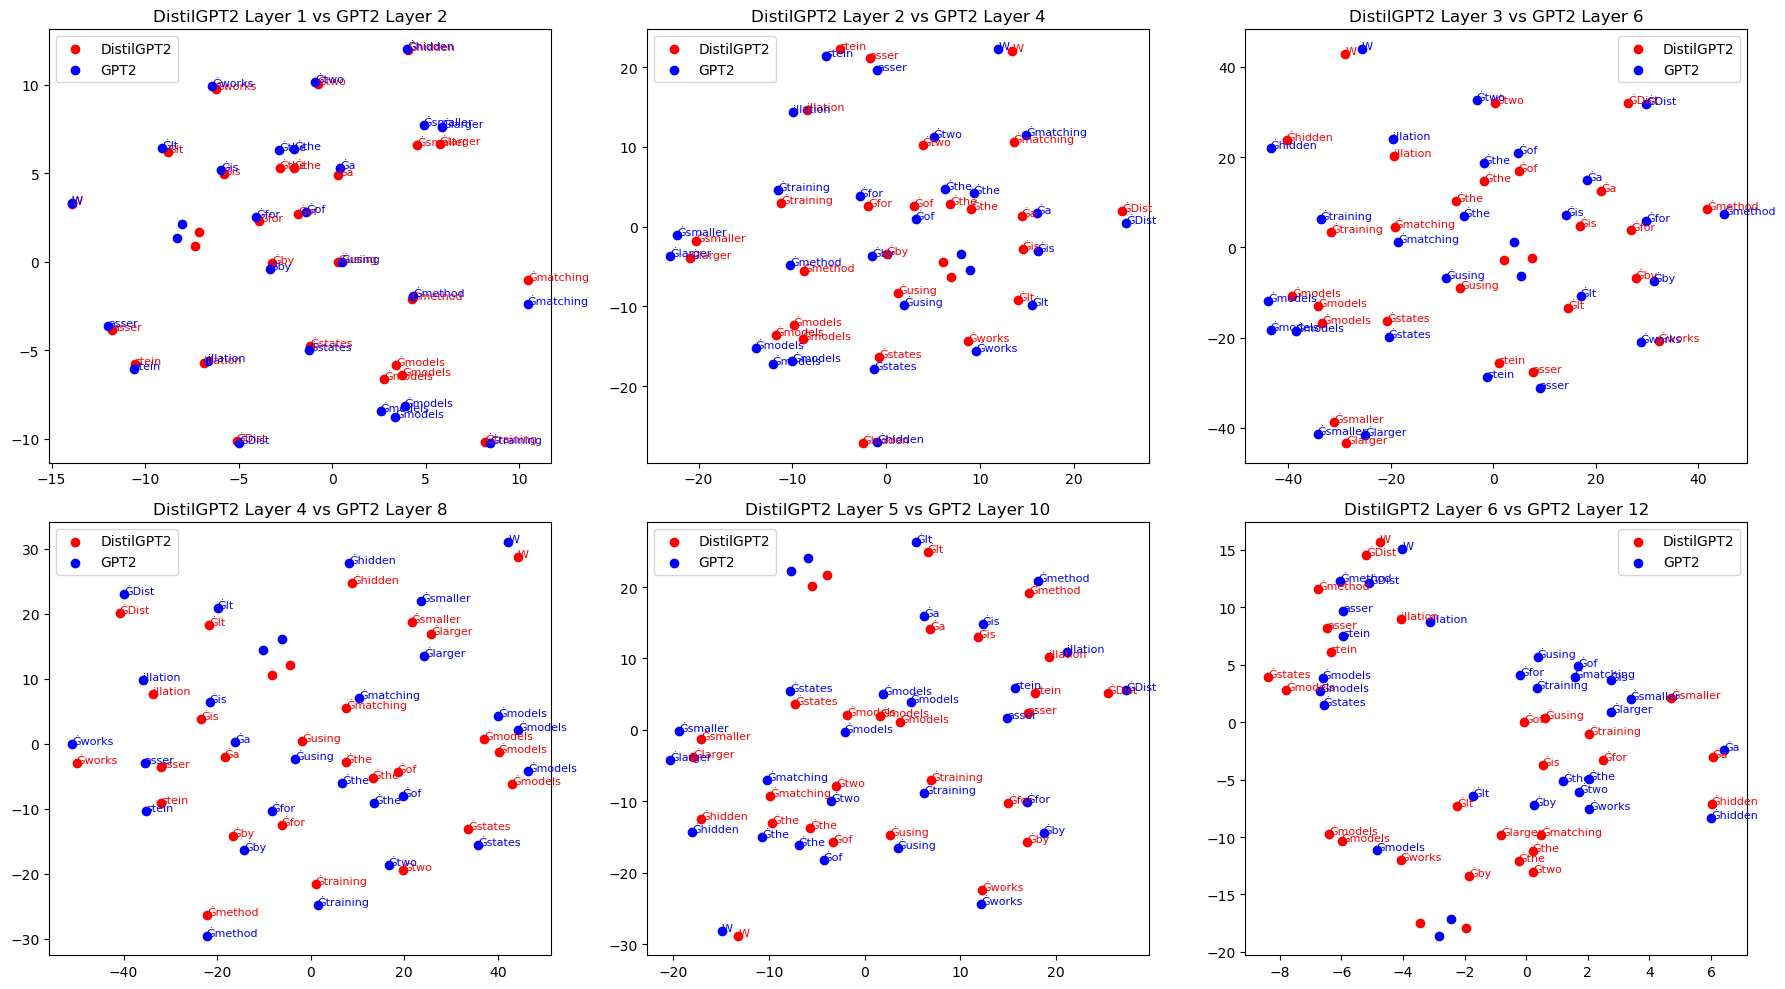

<Figure size 640x480 with 0 Axes>

In [1]:
from train_related import get_trained, getgpt2
import torch
from arguments import get_args
from lm_datasets import LMTrainDataset
from transformers import GPT2Config, GPT2LMHeadModel
from utils import get_tokenizer, get_model, get_teacher_model
from critic import critic
import evaluate
import random
import torch
import os
from torch.utils.data import Subset
import torch.distributed as dist
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import time
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel
import torch
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model, tokenizer = get_trained("/home/zyq/experiment_Wasserstein_Distillation/mains/distillated_student_KL/student_model_well-trained015000distill_step", device)
teacher_modek, tokenizer = getgpt2(device)
def t_SNE(student, teacher, tokenizer, device):
    # Prepare example text
    text = "Wasserstein Distillation is a method for training smaller models using larger models. It works by matching the hidden states of the two models."
    
    # Tokenize the input text and move to device
    inputs = tokenizer(text, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Ensure models are in eval mode
    student.eval()
    teacher.eval()
    
    # Forward pass with explicit config for hidden states
    with torch.no_grad():
        outputs_gpt2 = teacher(
            **inputs,
            output_hidden_states=True,
            return_dict=True
        )
        outputs_distilgpt2 = student(
            **inputs,
            output_hidden_states=True,
            return_dict=True
        )
    
    # Verify hidden states are available
    if outputs_gpt2.hidden_states is None or outputs_distilgpt2.hidden_states is None:
        raise ValueError("Hidden states not returned by the models. Check model configurations.")
    
    # Get tokens for visualization
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # Define layer pairs to align
    layer_pairs = [(1, 2), (2, 4), (3, 6), (4, 8), (5, 10), (6, 12)]
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # Convert hidden states to list if they're tuples
    hidden_states_gpt2 = list(outputs_gpt2.hidden_states)
    hidden_states_distilgpt2 = list(outputs_distilgpt2.hidden_states)
    
    for idx, (distil_layer_idx, gpt2_layer_idx) in enumerate(layer_pairs):
        try:
            # Get layer outputs and move to CPU for t-SNE
            distil_layer_output = hidden_states_distilgpt2[distil_layer_idx][0].cpu()
            gpt2_layer_output = hidden_states_gpt2[gpt2_layer_idx][0].cpu()
            
            # Concatenate embeddings
            combined_embeddings = torch.cat([distil_layer_output, gpt2_layer_output], dim=0).numpy()
            
            # Calculate safe perplexity value
            n_samples = combined_embeddings.shape[0]
            perplexity = min(10, max(2, n_samples - 1))  # Ensure perplexity is at least 2
            
            # Perform t-SNE
            tsne = TSNE(
                n_components=2,
                random_state=42,
                init='pca',
                learning_rate='auto',
                perplexity=perplexity
            )
            tsne_results = tsne.fit_transform(combined_embeddings)
            
            # Split results for both models
            n_tokens = distil_layer_output.shape[0]
            distil_points = tsne_results[:n_tokens]
            gpt2_points = tsne_results[n_tokens:]
            
            # Plot points
            ax = axes[idx]
            ax.scatter(distil_points[:, 0], distil_points[:, 1], color='red', label='DistilGPT2')
            ax.scatter(gpt2_points[:, 0], gpt2_points[:, 1], color='blue', label='GPT2')
            
            # Add token labels
            for i, (x, y) in enumerate(distil_points):
                ax.text(x, y, tokens[i], color='red', fontsize=8)
            for i, (x, y) in enumerate(gpt2_points):
                ax.text(x, y, tokens[i], color='blue', fontsize=8)
                
            ax.set_title(f"DistilGPT2 Layer {distil_layer_idx} vs GPT2 Layer {gpt2_layer_idx}")
            ax.legend()
            
        except Exception as e:
            print(f"Error processing layer pair ({distil_layer_idx}, {gpt2_layer_idx}): {str(e)}")
            ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    
    plt.tight_layout()
    
t_SNE(student_model, teacher_modek, tokenizer, device)

        

In [37]:
from train_related import calculate_perplexity, get_trained, get_gpt2dolly
from cnn_dataset import CNNDMDistillationDataset

from datasets import load_from_disk
import torch
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = "/home/zyq/experiment_Wasserstein_Distillation/mains/distillated_student_KL/student_model_well-trained19distill_step"
MSE_path = "/home/zyq/experiment_Wasserstein_Distillation/mains/distillated_student_KL/student_model_well-trained11kl_MSE_step"
model, tokenizer = get_trained(MSE_path, device)
# 加载本地保存的 CNN/DailyMail 数据集
dataset_path = "/home/zyq/experiment_Wasserstein_Distillation/experiment_DistillBERT/cnn_data/CNN"  # 替换为本地保存的路径
dataset = load_from_disk(dataset_path)
tokenizer.pad_token = tokenizer.eos_token

data = CNNDMDistillationDataset(dataset["validation"], tokenizer)

calculate_perplexity(model, tokenizer, data, device)


22.71350860595703

In [35]:
teacher, _ = get_gpt2dolly(device)

In [36]:
input = "Today we "
inputs = tokenizer(input, return_tensors="pt")
inputs.to(device)
# Generate the text
output = model.generate(**inputs, max_length=100, top_k = 1)
teacher_output = teacher.generate(**inputs, max_length=100, top_k = 1) 
print(tokenizer.decode(output[0], skip_special_tokens=True))
print(tokenizer.decode(teacher_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Today we  re-elected the president of the United States, and we re-elected the president of the United States, and we re-elected the president of the United States, and we re-elected the president of the United States, and we re-elected the president of the United States, and we re-elected the president of the United States, and we re-elected the president of the United States, and we re-elected the president
Today we  have a lot of work to do to get the game out there. We have to get the game out there and we have to get the community involved. We have to get the community involved and we have to get the community involved. We have to get the community involved and we have to get the community involved. We have to get the community involved and we have to get the community involved. We have to get the community involved and we have to get the community involved. We


In [ ]:
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import time

def load_models():
    """
    加载BERT和DistilBERT模型，设置最大长度限制 # load BERT and DistilBERT models, set maximum length limit
    """
    models = {}
    for model_name in ["textattack/bert-base-uncased-imdb", "textattack/distilbert-base-uncased-imdb"]:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        classifier = pipeline(
            "sentiment-analysis",
            model=model,
            tokenizer=tokenizer,
            device=0 if torch.cuda.is_available() else -1,
            batch_size=32,
            max_length=512,  # 设置最大长度 # set maximum length
            truncation=True  # 启用截断 # enable truncation 
        )
        models[model_name] = classifier
    return models

def load_imdb_dataset(split="test", num_samples=None):
    """
    加载IMDB数据集 # load IMDB dataset
    """
    dataset = load_dataset("imdb", split=split)
    if num_samples:
        dataset = dataset.select(range(num_samples))
    return dataset

def evaluate_model(classifier, dataset):
    """
    评估模型性能，处理长文本 # evaluate model performance, handle long texts
    """
    start_time = time.time()
    
    # 获取预测结果 # get predictions
    predictions = []
    texts = dataset["text"]
    
    # 使用批处理来提高效率 # use batch processing to improve efficiency
    batch_size = 32
    for i in tqdm(range(0, len(texts), batch_size), desc="Evaluating"):
        batch_texts = texts[i:i + batch_size]
        try:
            results = classifier(list(batch_texts))
            batch_predictions = [1 if result["label"] == "POSITIVE" else 0 for result in results]
            predictions.extend(batch_predictions)
        except Exception as e:
            print(f"Error processing batch starting at index {i}: {str(e)}")
            # 如果批处理失败，尝试逐个处理 # if batch processing fails, try to process one by one
            for text in batch_texts:
                try:
                    result = classifier(text)
                    pred_label = 1 if result[0]["label"] == "POSITIVE" else 0
                    predictions.append(pred_label)
                except Exception as e:
                    print(f"Error processing individual text: {str(e)}")
                    # 如果处理失败，假设为中性预测 
                    predictions.append(0)
    
    # 计算评估指标 # calculate evaluation metrics
    true_labels = dataset["label"]
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    evaluation_time = time.time() - start_time
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix,
        "evaluation_time": evaluation_time
    }

def print_evaluation_results(model_name, metrics):
    """
    打印评估结果 # print evaluation results
    """
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Evaluation Time: {metrics['evaluation_time']:.2f} seconds")
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])

def main():
    # 设置评估样本数量（设置为None使用全部测试集） # set the number of evaluation samples (set to None to use the entire test set)
    num_samples = 10000  # 可以调整或设置为None # can be adjusted or set to None
    
    # 加载数据集 # load dataset
    print("Loading IMDB dataset...")
    dataset = load_imdb_dataset(num_samples=num_samples)
    
    # 加载模型 # load models
    print("Loading models...")
    models = load_models()
    
    # 评估每个模型 # evaluate each model
    results = {}
    for model_name, classifier in models.items():
        print(f"\nEvaluating {model_name}...")
        metrics = evaluate_model(classifier, dataset)
        results[model_name] = metrics
        print_evaluation_results(model_name, metrics)
        
    # 比较模型性能 # compare model performance
    print("\nPerformance Comparison:")
    print("Model               Accuracy  F1 Score  Time(s)")
    print("-" * 50)
    for model_name, metrics in results.items():
        name = model_name.split("/")[-1]
        print(f"{name:18} {metrics['accuracy']:.4f}   {metrics['f1']:.4f}    {metrics['evaluation_time']:.2f}")

main()

Loading IMDB dataset...


KeyboardInterrupt: 

In [8]:
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import time

def load_models():
    """
    加载BERT和DistilBERT模型，设置最大长度限制 # load BERT and DistilBERT models, set maximum length limit
    """
    models = {}
    for model_name in ["textattack/bert-base-uncased-imdb", "textattack/distilbert-base-uncased-imdb"]:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        
        # 检查模型的标签映射 # check the label mapping of the model
        id2label = model.config.id2label
        print(f"\nModel {model_name} label mapping:")
        print(id2label)
        
        classifier = pipeline(
            "sentiment-analysis",
            model=model,
            tokenizer=tokenizer,
            device=0 if torch.cuda.is_available() else -1,
            batch_size=32,
            max_length=512,
            truncation=True
        )
        models[model_name] = (classifier, id2label)
    return models

def load_imdb_dataset(split="test", num_samples=None):
    """
    加载IMDB数据集 # load IMDB dataset
    """
    dataset = load_dataset("imdb", split=split)
    if num_samples:
        dataset = dataset.select(range(num_samples))
    return dataset

def map_label_to_id(label, id2label):
    """
    将模型输出的文本标签映射到数值标签 # map the text label output by the model to a numerical label
    """
    # 反转id2label字典 # reverse the id2label dictionary
    label2id = {v: k for k, v in id2label.items()}
    return int(label2id[label])

def evaluate_model(classifier, id2label, dataset):
    """
    评估模型性能，正确处理标签映射 # evaluate model performance, correctly handle label mapping
    """
    start_time = time.time()
    predictions = []
    texts = dataset["text"]
    
    # 批量处理预测 # batch processing predictions
    batch_size = 32
    for i in tqdm(range(0, len(texts), batch_size), desc="Evaluating"):
        batch_texts = texts[i:i + batch_size]
        try:
            results = classifier(list(batch_texts))
            # 使用正确的标签映射 # use the correct label mapping    
            batch_predictions = [map_label_to_id(result["label"], id2label) for result in results]
            predictions.extend(batch_predictions)
        except Exception as e:
            print(f"Error processing batch starting at index {i}: {str(e)}")
            # 单个处理有问题的批次 # process problematic batches one by one # process problematic batches one by one
            for text in batch_texts:
                try:
                    result = classifier(text)
                    pred_label = map_label_to_id(result[0]["label"], id2label)
                    predictions.append(pred_label)
                except Exception as e:
                    print(f"Error processing individual text: {str(e)}")
                    predictions.append(0)  # 默认预测 # default prediction

    # 计算评估指标 # calculate evaluation metrics
    true_labels = dataset["label"]
    
    # 确保使用正确的标签进行评估 # ensure correct labels are used for evaluation
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, 
        predictions, 
        average='binary',
        zero_division=0
    )
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    evaluation_time = time.time() - start_time
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix,
        "evaluation_time": evaluation_time
    }

def print_evaluation_results(model_name, metrics):
    """
    打印评估结果 # print evaluation results
    """
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Evaluation Time: {metrics['evaluation_time']:.2f} seconds")
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])

def main():
    # 设置评估样本数量 # set the number of evaluation samples
    num_samples = 25000  # 可以调整或设置为None使用全部测试集 # can be adjusted or set to None to use the entire test set
    
    print("Loading IMDB dataset...")
    dataset = load_imdb_dataset(num_samples=num_samples)
    
    print("Loading models...")
    models = load_models()
    
    # 评估每个模型 # evaluate each model
    results = {}
    for model_name, (classifier, id2label) in models.items():
        print(f"\nEvaluating {model_name}...")
        metrics = evaluate_model(classifier, id2label, dataset)
        results[model_name] = metrics
        print_evaluation_results(model_name, metrics)
    
    # 比较模型性能 # compare model performance
    print("\nPerformance Comparison:")
    print("Model               Accuracy  F1 Score  Time(s)")
    print("-" * 50)
    for model_name, metrics in results.items():
        name = model_name.split("/")[-1]
        print(f"{name:18} {metrics['accuracy']:.4f}   {metrics['f1']:.4f}    {metrics['evaluation_time']:.2f}")

main()

Loading IMDB dataset...


Loading models...


Device set to use cuda:0



Model textattack/bert-base-uncased-imdb label mapping:
{0: 'LABEL_0', 1: 'LABEL_1'}


Device set to use cuda:0



Model textattack/distilbert-base-uncased-imdb label mapping:
{0: 'LABEL_0', 1: 'LABEL_1'}

Evaluating textattack/bert-base-uncased-imdb...


Evaluating: 100%|██████████| 782/782 [02:12<00:00,  5.88it/s]



Results for textattack/bert-base-uncased-imdb:
Accuracy: 0.9303
Precision: 0.9425
Recall: 0.9165
F1 Score: 0.9293
Evaluation Time: 133.08 seconds

Confusion Matrix:
[[11801   699]
 [ 1044 11456]]

Evaluating textattack/distilbert-base-uncased-imdb...


Evaluating: 100%|██████████| 782/782 [01:18<00:00,  9.91it/s]


Results for textattack/distilbert-base-uncased-imdb:
Accuracy: 0.9244
Precision: 0.9342
Recall: 0.9132
F1 Score: 0.9236
Evaluation Time: 79.01 seconds

Confusion Matrix:
[[11696   804]
 [ 1085 11415]]

Performance Comparison:
Model               Accuracy  F1 Score  Time(s)
--------------------------------------------------
bert-base-uncased-imdb 0.9303   0.9293    133.08
distilbert-base-uncased-imdb 0.9244   0.9236    79.01


In [7]:
!pip install --upgrade datasets


In [2]:
from datasets import load_dataset
import os
#use huggingface mirror
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
# 加载 OpenWebText 数据集 # load OpenWebText dataset
dataset = load_dataset("Skylion007/openwebtext")

# 保存到本地文件夹 # save to local folder
save_path = "/home/zyq/experiment_Wasserstein_Distillation/mains/opentext_dataset"
dataset.save_to_disk(save_path)

print(f"the dataset has been saved to the local path: {save_path}") 


TypeError: 'NoneType' object is not callable

In [ ]:
from train_related import save_student_model, example_gen, top_p_sampling, get_student_model, \
    get_gpt2dolly, get_distillgpt2, getgpt2, calculate_perplexity, preprocess_function, \
    evaluate_model_with_rouge, get_distillgpt2_with_reset, t_SNE, get_trained, getgpt2
    
from arguments import get_args
from lm_datasets import LMTrainDataset
from transformers import GPT2Config, GPT2LMHeadModel
from utils import get_tokenizer, get_model, get_teacher_model
from critic import critic
#from evaluate import evaluate
import evaluate
import random
import torch
import os
from torch.utils.data import Subset
import torch.distributed as dist
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
from datasets import Dataset, load_from_disk
from torch.nn.parallel import DistributedDataParallel as DDP
from train_related import save_student_model, example_gen, top_p_sampling, get_student_model, \
    get_gpt2dolly, get_distillgpt2, getgpt2, preprocess_function, \
    evaluate_model_with_rouge, get_distillgpt2_with_reset, t_SNE, get_trained, getgpt2
from cnn_dataset import CNNDMDistillationDataset, OpenWebTextDataset
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist


In [6]:
def calculate_perplexity(model, tokenizer, test_dataset, device):
    model.eval()
    total_loss = 0
    total_tokens = 0

    dataloader = DataLoader(test_dataset, batch_size=32)

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Get loss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss

            # Weighted by the number of tokens
            total_loss += loss.item() * input_ids.size(1)
            total_tokens += input_ids.size(1)

    # Sync across all GPUs
    total_loss_tensor = torch.tensor(total_loss, device=device, dtype=torch.float64)
    total_tokens_tensor = torch.tensor(total_tokens, device=device, dtype=torch.float64)

    total_loss = total_loss_tensor.item()
    total_tokens = total_tokens_tensor.item()

    # Compute perplexity on rank 0
    perplexity = None
    
    if total_tokens > 0:
            perplexity = torch.exp(torch.tensor(total_loss / total_tokens, device=device))
    else:
            perplexity = torch.tensor(float('inf'), device=device)

    # Broadcast perplexity to all ranks
    perplexity_tensor = torch.zeros(1, device=device)
    if perplexity is not None:
        perplexity_tensor[0] = perplexity

    return perplexity_tensor.item()


In [7]:
device = torch.device(f"cuda:{5}" if torch.cuda.is_available() else "cpu")
teacher_model, tokenizer = get_distillgpt2(device)
dataset_path = "/home/zyq/experiment_Wasserstein_Distillation/mains/opentext_dataset"  # 替换为本地保存的路径
dataset = load_from_disk(dataset_path)
dataset = dataset["train"]
test_dataset = dataset.select(range(len(dataset) - 10000, len(dataset)))

data = OpenWebTextDataset(dataset=dataset,tokenizer=tokenizer,max_length=512)
test_dataset = OpenWebTextDataset(dataset=test_dataset,tokenizer=tokenizer,max_length=512)

ppl = calculate_perplexity(teacher_model, tokenizer, test_dataset, device)
print(f"Student Perplexity on validation set: {ppl}")

Loading dataset from disk:   0%|          | 0/73 [00:00<?, ?it/s]

Student Perplexity on validation set: 32.919002532958984
